# Wavelet Denoising

This numerical tour uses wavelets to perform non-linear
image denoising.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$


*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.

In [1]:
from __future__ import division
from nt_toolbox.general import *
from nt_toolbox.signal import *
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/nethome/asiahkoohi3/GATechBundle/Miniconda3/envs/gpu/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Image Denoising

We consider a simple generative model of noisy images $F = f_0+W$
where $f_0 \in \RR^N$ is a deterministic image of $N$ pixels, and
$W$ is a Gaussian white noise distributed according to $\Nn(0,\si^2
\text{Id}_N)$, where $\si^2$ is the variance of noise.

The goal of denoising is to define an estimator $\tilde F$ of
$f_0$ that depends only on $F$, i.e. $\tilde F = \phi(F)$
where $\phi : \RR^N \rightarrow \RR^N$ is a potentially non-linear
mapping.

Note that while $f_0$ is a deterministic image, both $F$ and $\tilde F$
are random variables (hence the capital letters). 

The goal of denoising is to reduce as much as possible the denoising
error given some prior knowledge on the (unknown) image $f_0$.
A mathematical way to measure this error is to bound the 
quadratic risk $\EE_w(\norm{\tilde F - f_0}^2)$, where the expectation is computed
with respect to the distribution of the noise $W$.

Image loading and adding Gaussian Noise
For real life applications, one does not have access to the underlying
image $f_0$. In this tour, we however assume that $f_0$ is known, and
$f = f_0 + w\in \RR^N$ is generated using a single realization of the noise $w$
that is drawn from $W$. We define the estimated deterministic image as 
$\tilde f = \phi(f)$ which is a realization of the random vector
$\tilde F$.


First we load an image $f_0 \in \RR^N$ where $N=n \times n$ is the number of pixels, and then display it.

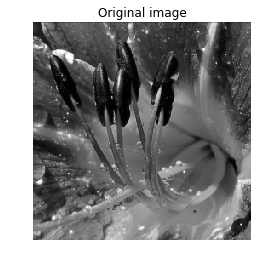

In [2]:
n = 256
name = 'nt_toolbox/data/flowers.png'
f0 = load_image(name, n)
imageplot(f0, 'Original image')

Standard deviation $\si$ of the noise.

In [3]:
sigma = .08

Then we add Gaussian noise $w$ to obtain $f=f_0+w$.

In [4]:
f = f0 + sigma*random.standard_normal(f0.shape)

Display the noisy image. 

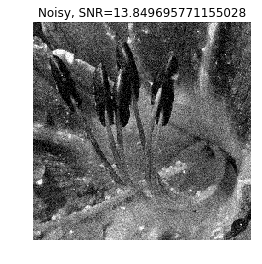

In [5]:
imageplot(clamp(f), 'Noisy, SNR=' + str(snr(f0,f)) )

## Hard Thresholding in Wavelet Bases

A simple but efficient non-linear denoising estimator is obtained by
thresholding the coefficients of $f$ in a well chosen orthogonal basis
$\Bb = \{\psi_m\}_m$ of $\RR^N$.

In the following, we will focuss on a wavelet basis, which is efficient
to denoise piecewise regular images.

The hard thresholding operator with threshold $T \geq 0$ applied to
some image $f$ is defined as
$$ S_T^0(f) = \sum_{\abs{\dotp{f}{\psi_m}}>T} \dotp{f}{\psi_m} \psi_m
       = \sum_m s_T^0(\dotp{f}{\psi_m}) \psi_m $$
where the hard thresholding operator is
$$
      s_T^0(\alpha) = \choice{
           \alpha \qifq \abs{\al}>T, \\
              0 \quad\text{otherwise}.
      }$
$$


The denoising estimator is then defined as
$$ \tilde f = S_T^0(f). $$

Display the function $s_T^0(\al)$ for $T=1$.

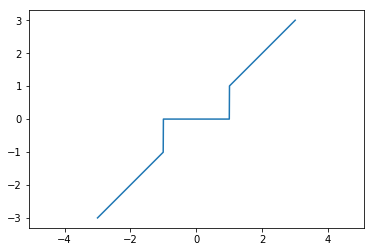

In [6]:
def thresh_hard(u,t):return u*(abs(u)>t)
alpha = linspace(-3,3,1000)
plot(alpha, thresh_hard(alpha,1))
axis('equal');

Parameters for the orthogonal wavelet transform.

In [7]:
h = [0, .482962913145, .836516303738, .224143868042, -.129409522551]
h = h/norm(h)
Jmin = 2

First we compute the wavelet coefficients $a$  
of the noisy image $f$.

In [8]:
a = perform_wavortho_transf(f,Jmin,+1,h)

Display the noisy coefficients.

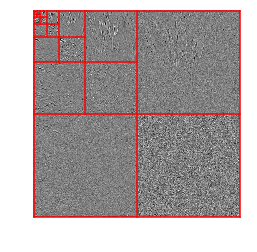

In [9]:
plot_wavelet(a,Jmin);

Select the threshold value, that should be proportional to the noise
level $\si$.

In [10]:
T = 3*sigma

Hard threshold the coefficients below the noise level to obtain $a_T(m)=s_T^0(a_m)$.

In [11]:
aT = thresh_hard(a,T)

Display the thresholded coefficients.

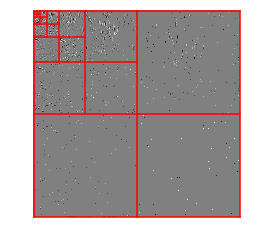

In [12]:
plot_wavelet(aT,Jmin);

Reconstruct the image $\tilde f$ from these noisy coefficients.

In [13]:
fHard = perform_wavortho_transf(aT,Jmin,-1,h)

Display the denoising result.

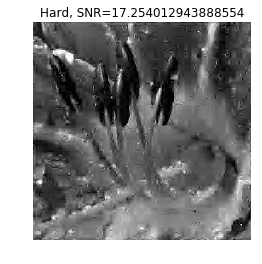

In [14]:
imageplot(clamp(fHard), 'Hard, SNR=' + str(snr(f0,fHard)) )

## Wavelet Denoising with Soft Thesholding

The estimated image $\tilde f$ using hard thresholding.
suffers from many artifacts. It is
possible to improve the result by using soft thresholding, 
defined as
$$ \tilde f = S_T^1(f) = \sum_m s_T^1(\dotp{f}{\psi_m}) \psi_m $$
$$
      \qwhereq
      s_T^1(\alpha) = \max\pa{0, 1 - \frac{T}{\abs{\alpha}}}\alpha.
$$

Display the soft thresholding function $s_T^1(\al)$.

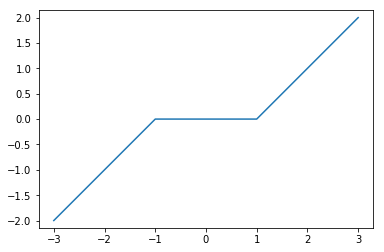

In [15]:
def thresh_soft(u,t):return maximum(1-t/abs(u), 0)*u
alpha = linspace(-3,3,1000)
plot(alpha, thresh_soft(alpha,1))
axis('equal');

Select the threshold.

In [16]:
T = 3/2*sigma

Perform the soft thresholding.

In [17]:
aT = thresh_soft(a,T)

To slightly improve the soft thresholding performance, we do not
threshold the coefficients corresponding to coarse scale wavelets. 

In [18]:
aT[:2^Jmin:,:2^Jmin:] = a[:2^Jmin:,:2^Jmin:]

Re-construct the soft thresholding estimator $\tilde f$.

In [19]:
fSoft = perform_wavortho_transf(aT,Jmin,-1,h)

Display the soft thresholding denoising result.

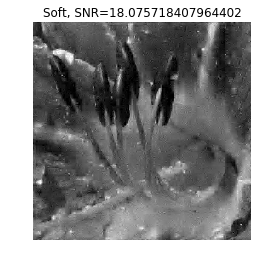

In [20]:
imageplot(clamp(fSoft), 'Soft, SNR=' + str(snr(f0,fSoft)) )

One can prove that if the non-linear approximation error 
$ \norm{f_0-S_T(f_0)}^2 $ decays fast toward zero when 
$T$ decreases, then the quadratic risk 
$ \EE_w( \norm{f-S_T(f)}^2 ) $ also decays fast to zero 
when $\si$ decays. For this result to hold, it is required
to select the threshold value according to the universal threshold rule
$$ T = \si \sqrt{2\log(N)}. $$

Determine the best threshold $T$ for both hard and soft thresholding.
Test several \(T\) values in $[.8\sigma, 4.5\sigma[$, 
and display the empirical SNR $-10\log_{10}(\norm{f_0-\tilde f}/\norm{f_0})$
What can you conclude from these results ? Test with another image.

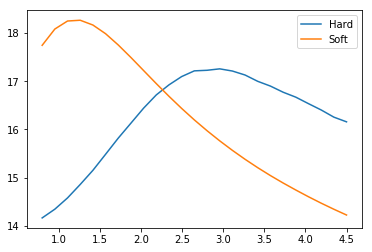

In [21]:
run -i nt_solutions/denoisingwav_2_wavelet_2d/exo1

## Translation Invariant Denoising with Cycle Spinning

Orthogonal wavelet transforms are not translation invariant.
It means that the processing of an image and of a translated version of
the image give different results.

Any denoiser can be turned into a translation invariant denoiser by
performing a cycle spinning. The denoiser is applied to several shifted
copies of the image, then the resulting denoised image are shifted back
to the original position, and the results are averaged.

This corresponds to defining the estimator as
$$ \tilde f = \frac{1}{M} \sum_{i=1}^{M}$
      T_{-\de_i} \circ S_T(f) \circ T_{\de_i}$$
where $S_T$ is either the hard or soft thresholding, 
and $T_\de(f)(x) = f(x-\de)$ is the translation operator, 
using periodic boundary conditions. 
Here $(\de_i)_i$ is a set of $M$ discrete translation. Perfect invariance
is obtained by using all possible $N$ translatation, but 
usually a small number $M \ll N$ of translation is used to obtain approximate
invariance.

Number $m$ of translations along each direction
so that $M = m^2$. 

In [22]:
m = 4

Generate a set of shifts $(\de_i)_i$.

In [23]:
[dY,dX] = meshgrid(arange(0,m),arange(0,m))
delta = concatenate( (dX.reshape(m*m,1), dY.reshape(m*m,1)), axis=1)

To avoid storing all the translates in memory, one can perform a
progressive averaging of the translates by defining $f^{(0)}=0$ and
then
$$ \forall\, i=1,\ldots,M, \quad f^{(i)} = \pa{1-\frac{i}{n}} f^{(i-1)} + 
      \frac{i}{n} T_{-\de_i} \circ S_T(f) \circ T_{\de_i}  $$
One then has $\tilde f = f^{(M)} $ after $M$ steps.

Initialize the denoised image $f^{(0)}=0$.

In [24]:
fTI = zeros([n,n])
T = 3*sigma
for i in arange(0,m*m):
    fS = circshift(f,delta[i,:])
    a = perform_wavortho_transf(fS,Jmin,1,h)
    aT = thresh_hard(a,T)
    fS = perform_wavortho_transf(aT,Jmin,-1,h)
    fS = circshift(fS,-delta[i,:])
    fTI = i/(i+1.0)*fTI + 1.0/(i+1)*fS

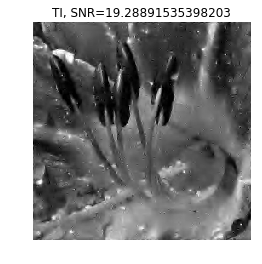

In [25]:
imageplot(clamp(fTI), 'TI, SNR=' + str(snr(f0,fTI)) )

# Exercises

*Exercise 1:* Study the influence of the number $m$ of shift on the denoising
quality.

*Exercise 2:* Select the best threshold $T$ for the translation invariant denoising.

*Exercise 3:* Implement a block-thresholding method, that threshold coefficient in square blocks according to the energy of each of these blocks.